In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split



import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2


from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image


from pathlib import Path
import os.path


from sklearn.metrics import classification_report, confusion_matrix

# !curl -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



from helper_functions1 import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

<h1> Model 0 

<h3> MobileNetV2 with CNN

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

dataset = "data/"
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))  + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.gif'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# random_index = np.random.randint(0, len(image_df), 16)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
#     ax.set_title(image_df.Label[random_index[i]])
# plt.tight_layout()
# plt.show()

<h3>Training the model with images

In [9]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 15 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 15 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 3953 validated image filenames belonging to 2 classes.
Found 988 validated image filenames belonging to 2 classes.
Found 1233 validated image filenames belonging to 2 classes.


c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 6 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])


# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

# Create checkpoint callback
checkpoint_path = "smokers_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "smoker_classification"),
        checkpoint_callback,
    ]
)


#save the model as .h5
model.save('smoker_classification_model.h5')

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 15 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 15 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 3953 validated image filenames belonging to 2 classes.
Found 988 validated image filenames belonging to 2 classes.


c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 6 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 1233 validated image filenames belonging to 2 classes.
Saving TensorBoard log files to: training_logs/smoker_classification/20231202-202357
Epoch 1/100
124/124 [==============================] - 76s 546ms/step - loss: 3.2735 - accuracy: 0.5151 - val_loss: 2.0092 - val_accuracy: 0.6194
Epoch 2/100
124/124 [==============================] - 53s 424ms/step - loss: 2.2054 - accuracy: 0.5684 - val_loss: 1.5959 - val_accuracy: 0.6336
Epoch 3/100
124/124 [==============================] - 52s 418ms/step - loss: 1.7414 - accuracy: 0.5983 - val_loss: 1.3482 - val_accuracy: 0.6407
Epoch 4/100
124/124 [==============================] - 52s 424ms/step - loss: 1.5395 - accuracy: 0.6041 - val_loss: 1.1447 - val_accuracy: 0.6427
Epoch 5/100
124/124 [==============================] - 52s 421ms/step - loss: 1.3964 - accuracy: 0.6104 - val_loss: 0.9303 - val_accuracy: 0.6589
Epoch 6/100
124/124 [==============================] - 52s 424ms/step - loss: 1.2090 - accuracy: 0.6466 - val_loss: 0.8558 -

In [3]:
#load model
model = tf.keras.models.load_model('smoker_classification_model.h5')

Testing for images as well

In [12]:


# Load and preprocess the single image
image_path = 'data/smoking/000002.jpg'  # Replace with the actual path to your image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Make prediction using the loaded model
prediction = model.predict(img_array)
predicted_label = np.argmax(prediction)
print(prediction)
print(predicted_label)
# Map the predicted label
label_map = {v: k for k, v in train_images.class_indices.items()}
predicted_label_name = label_map[predicted_label]

# Display the result
print(f'The predicted label for the single image is: {predicted_label_name}')


[[0.00799771 0.99200225]]
1
The predicted label for the single image is: smoking


Skip frames for better performance, need to fine tune more

In [65]:

def extract_frames(video_path, frame_size,skip_frames=1):
    # Initialize a list to hold frames
    frames = []
    frame_count = 0
    
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    while True:
        
        # Read a frame from the video file
        ret, frame = video.read()
        
        # If the frame was successfully read
        if ret:
            if frame_count % skip_frames == 0:
                # Resize the frame
                frame = cv2.resize(frame, frame_size)
                
                # Normalize pixel values (if necessary)
                frame = frame / 255.0
                
                # Add the frame to the list of frames
                frames.append(frame)
            frame_count += 1
        else:
            # If no frame was read then we've reached the end of the video
            break
    
    # Release the video file
    video.release()
    
    # Convert the list of frames to a numpy array
    frames = np.array(frames)
    
    return frames

# Use the function to extract frames from a video file
video_path = 'train/explicit/SaveInsta.App - 3246691312396271309_27953746084.mp4'
frames = extract_frames(video_path, (224, 224))

# Make sure the frames array is 4-dimensional
if len(frames.shape) == 3:
    frames = np.expand_dims(frames, axis=0)

# Use the frames as input to your model
predictions = model.predict(frames)


In [61]:
print(predictions)

[[0.13226709 0.8677329 ]
 [0.185941   0.814059  ]
 [0.9533107  0.04668928]
 [0.9285572  0.07144278]
 [0.91874385 0.08125614]
 [0.8126715  0.1873285 ]
 [0.8618328  0.13816719]
 [0.8529463  0.14705373]
 [0.7507126  0.24928744]
 [0.8840884  0.11591166]
 [0.6946029  0.3053971 ]
 [0.573477   0.42652297]
 [0.42431042 0.5756896 ]
 [0.33936092 0.6606391 ]
 [0.21329811 0.78670186]
 [0.5318479  0.46815208]
 [0.0687549  0.9312451 ]
 [0.10640484 0.8935951 ]
 [0.18628491 0.81371504]
 [0.2867638  0.7132362 ]
 [0.53039426 0.46960574]
 [0.32766426 0.67233574]
 [0.29455414 0.7054459 ]
 [0.3124759  0.6875241 ]
 [0.2834029  0.71659714]
 [0.1512484  0.84875166]
 [0.9859839  0.01401612]
 [0.9634031  0.03659693]
 [0.9727842  0.02721582]
 [0.9874462  0.0125538 ]
 [0.9712602  0.02873988]
 [0.9748785  0.02512158]
 [0.98459643 0.01540355]
 [0.9925706  0.00742947]
 [0.9931657  0.00683427]
 [0.99158996 0.00841011]
 [0.96496147 0.03503855]
 [0.90342605 0.09657393]
 [0.9568131  0.0431869 ]
 [0.93081254 0.06918751]


In [66]:
#get the avg value of predictions
predicted_label1 = np.mean(predictions,axis=0)
print(predicted_label1)

predicted_label2 = np.argmax(predicted_label1)

label_map = {v: k for k, v in train_images.class_indices.items()}
predicted_label_name = label_map[predicted_label2]

# Display the result
print(f'The predicted label for the video is: {predicted_label_name}')
#print number of frames 
print(len(frames))

[0.66922593 0.33077437]
The predicted label for the video is: not_smoking
277


Trail for early break if smoking in one frame is found <br>
Leads to more false positives

In [82]:
def extract_frames_and_predict(video_path, frame_size, model, skip_frames=10):
    # Initialize a list to hold frames
    frames = []
    
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    frame_count = 0
    while True:
        # Read a frame from the video file
        ret, frame = video.read()
        
        # If the frame was successfully read
        if ret:
            # Process every nth frame
            if frame_count % skip_frames == 0:
                # Resize the frame
                frame = cv2.resize(frame, frame_size)
                
                # Normalize pixel values (if necessary)
                frame = frame / 255.0
                
                # Add the frame to the list of frames
                frames.append(frame)
                
                # Convert the list of frames to a numpy array
                frames_array = np.array(frames)
                
                # Make sure the frames array is 4-dimensional
                if len(frames_array.shape) == 3:
                    frames_array = np.expand_dims(frames_array, axis=0)
                
                # Use the frames as input to your model
                predictions = model.predict(frames_array)
                print(predictions)
                predicted_label = predictions[-1]
                print(predicted_label)
                predicted_label = np.argmax(predicted_label)
                #only predict the latest frame
                
                
                
                label_map = {v: k for k, v in train_images.class_indices.items()}
                predicted_label = label_map[predicted_label]
                # If the model predicts 'smoking', break the loop
                if predicted_label == 'smoking':
                    break
                
            frame_count += 1
        else:
            # If no frame was read then we've reached the end of the video
            break
    
    # Release the video file
    video.release()
    
    return predicted_label

#predict
predicted_label = extract_frames_and_predict('test/Etrain9.mp4', (224, 224), model, skip_frames=10)
print(predicted_label)

[[0.85099626 0.14900371]]
[0.85099626 0.14900371]
[[0.85099685 0.14900316]
 [0.42321184 0.5767882 ]]
[0.42321184 0.5767882 ]
smoking


In [10]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

C:\Users\welcome\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.27896
Test Accuracy: 90.59%


In [12]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [22]:
y_test = list(test_df.Label)

y_test = y_test[:len(pred)]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

 not_smoking       0.39      0.33      0.36       447
     smoking       0.65      0.70      0.67       786

    accuracy                           0.57      1233
   macro avg       0.52      0.52      0.52      1233
weighted avg       0.55      0.57      0.56      1233



In [72]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

C:\Users\welcome\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The first 5 predictions: ['smoking', 'smoking', 'smoking', 'smoking', 'smoking']


IndexError: list index out of range

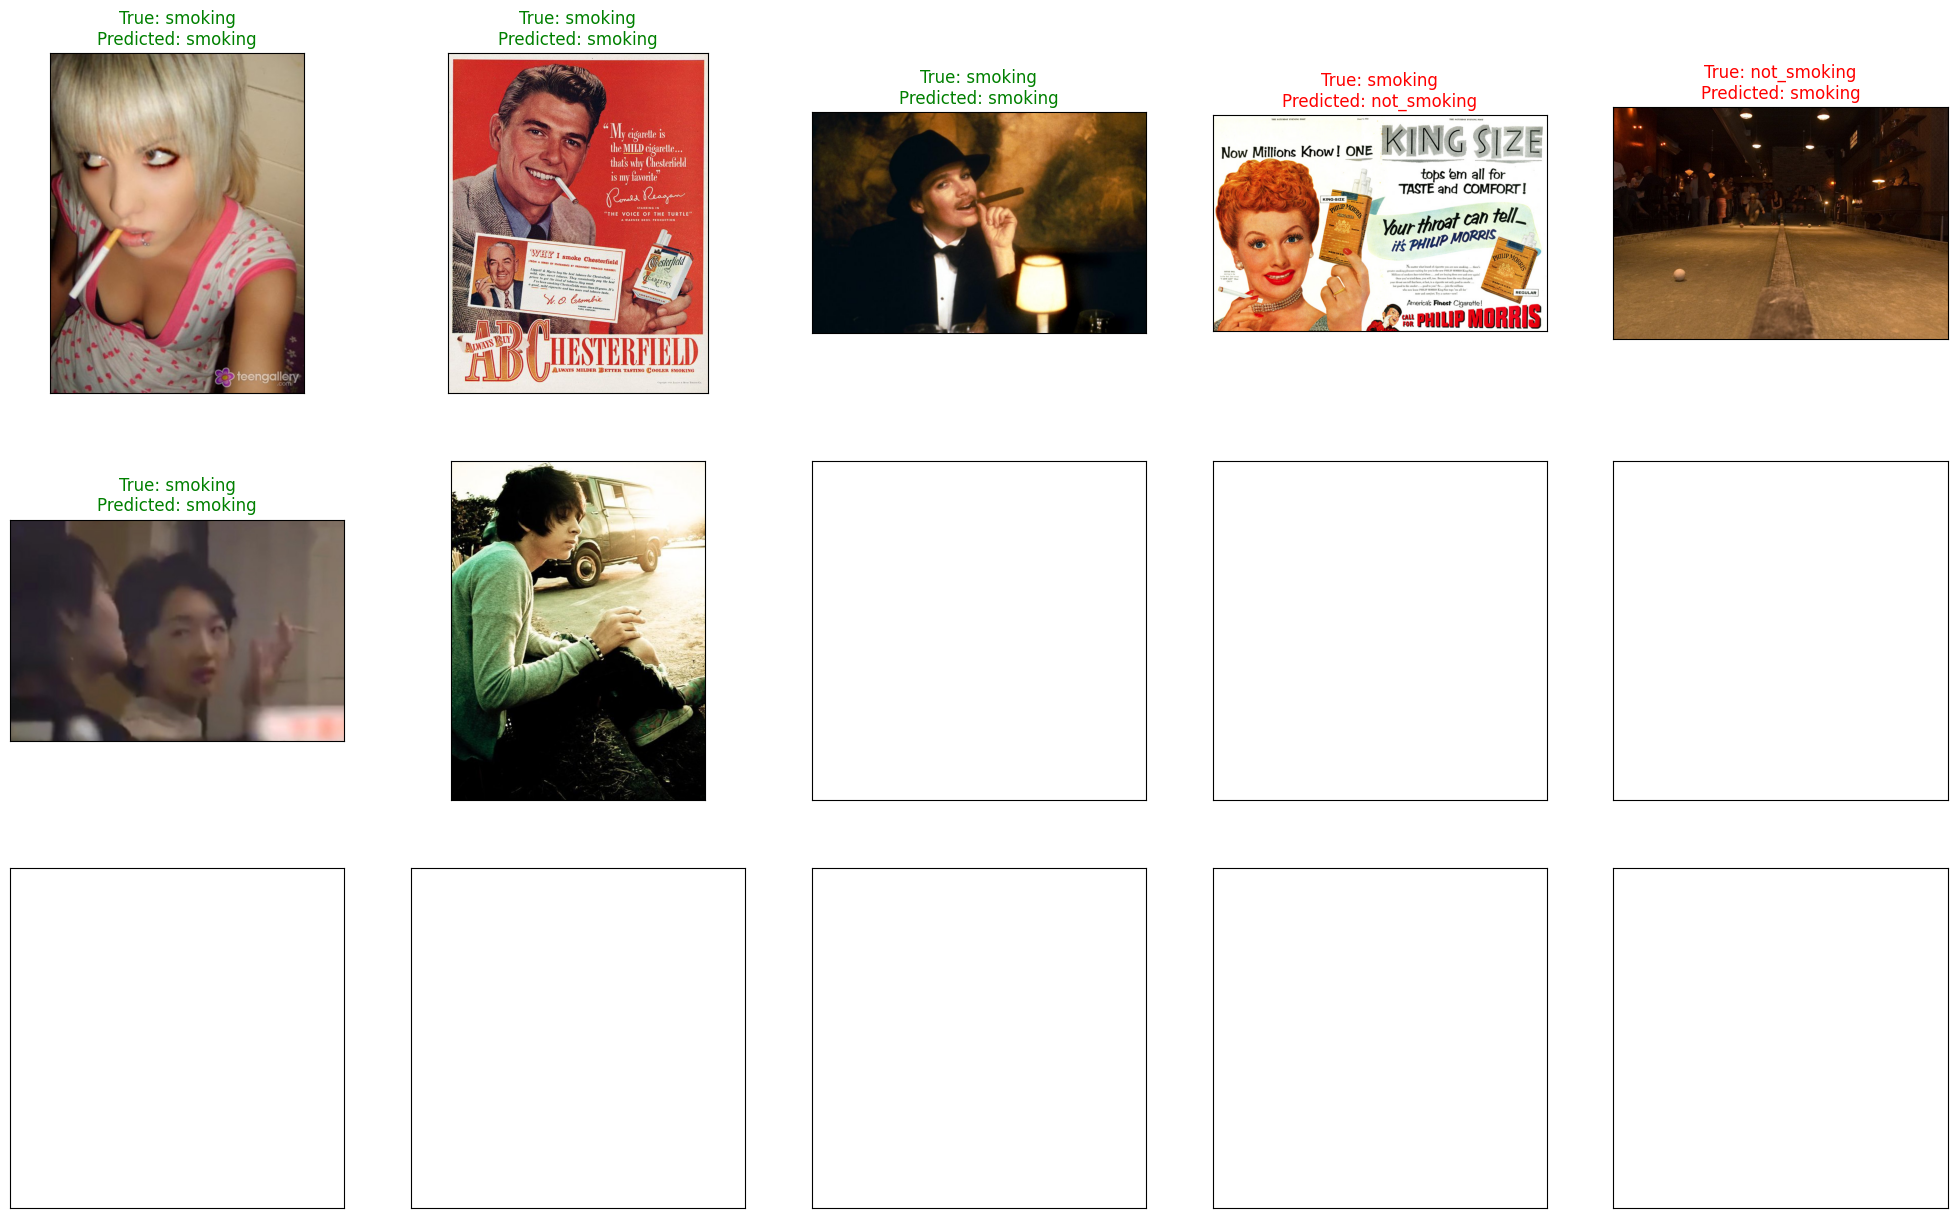

In [73]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()